# Perceptrón y Kernels

# Perceptrón: introducción y notación lineal

El **perceptrón** es un clasificador lineal que decide entre dos clases a partir de una combinación lineal de las características.

## Notación

**Vectores y parámetros**

$$
\mathbf{x}\in\mathbb{R}^d \quad\text{(vector de características)}
$$

$$
y\in\{-1,+1\} \quad\text{(etiqueta binaria)}
$$

$$
\mathbf{w}\in\mathbb{R}^d \quad\text{(vector de pesos)}
$$

$$
b\in\mathbb{R} \quad\text{(sesgo o bias)}
$$

**Forma aumentada (absorbe el sesgo):**

$$
\tilde{\mathbf{x}}=
\begin{pmatrix}
\mathbf{x}\\[2pt]
1
\end{pmatrix},
\qquad
\tilde{\mathbf{w}}=
\begin{pmatrix}
\mathbf{w}\\[2pt]
b
\end{pmatrix}
$$

## Regla de decisión

$$
s=\mathbf{w}^\top\mathbf{x}+b
\quad\Rightarrow\quad
\hat{y}=\operatorname{sign}(s)
$$

En forma aumentada:

$$
\hat{y}=\operatorname{sign}\!\big(\tilde{\mathbf{w}}^\top\tilde{\mathbf{x}}\big)
$$

La frontera de decisión es el hiperplano:

$$
\{\mathbf{x}\in\mathbb{R}^d:\ \mathbf{w}^\top\mathbf{x}+b=0\}
$$

## Forma matricial (lote)

Con \(n\) ejemplos:

$$
X\in\mathbb{R}^{n\times d},\qquad
\mathbf{y}\in\{-1,+1\}^n,\qquad
\mathbf{1}\in\mathbb{R}^{n}
$$

Puntajes para todo el lote:

$$
\mathbf{s}=X\mathbf{w}+b\,\mathbf{1}
\quad\Rightarrow\quad
\hat{\mathbf{y}}=\operatorname{sign}(\mathbf{s})
$$

Usando la forma aumentada:

$$
\tilde{X}=\begin{bmatrix}X&\mathbf{1}\end{bmatrix},\qquad
\mathbf{s}=\tilde{X}\tilde{\mathbf{w}},\qquad
\hat{\mathbf{y}}=\operatorname{sign}(\tilde{X}\tilde{\mathbf{w}})
$$

## Regla de actualización (online)

Si $$((\mathbf{x}_i, y_i))$$ está mal clasificado, es decir:

$$
y_i\,(\mathbf{w}^\top \mathbf{x}_i + b) \le 0,
$$

entonces:

$$
\mathbf{w}\leftarrow \mathbf{w}+\eta\,y_i\,\mathbf{x}_i,
\qquad
b\leftarrow b+\eta\,y_i
$$

Forma aumentada:

$$
\tilde{\mathbf{w}}\leftarrow \tilde{\mathbf{w}}+\eta\,y_i\,\tilde{\mathbf{x}}_i
$$

> Esta formulación vectorizada permite implementar el perceptrón de forma directa con NumPy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Perceptrón en 2 dimensiones

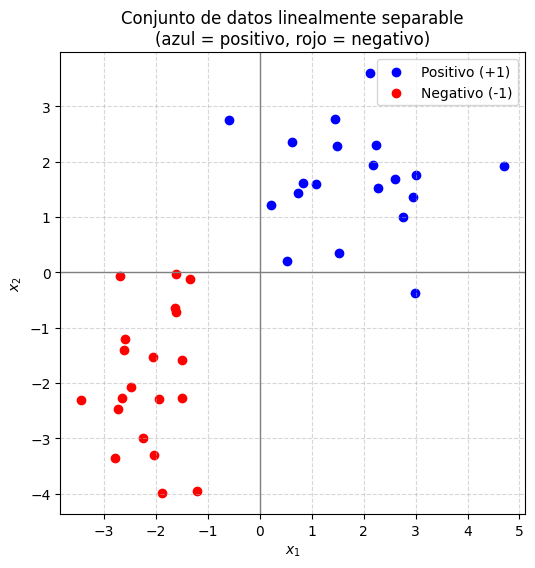

In [2]:
# Configurar semilla para reproducibilidad
np.random.seed(1010)

# Generar puntos positivos (azules)
x_pos = np.random.randn(20, 2) + np.array([2, 2])
y_pos = np.ones(len(x_pos))

# Generar puntos negativos (rojos)
x_neg = np.random.randn(20, 2) + np.array([-2, -2])
y_neg = -np.ones(len(x_neg))

# Combinar en un solo conjunto
X = np.vstack([x_pos, x_neg])
y = np.concatenate([y_pos, y_neg])

# Graficar puntos
plt.figure(figsize=(6, 6))
plt.scatter(x_pos[:, 0], x_pos[:, 1], color='blue', label='Positivo (+1)')
plt.scatter(x_neg[:, 0], x_neg[:, 1], color='red', label='Negativo (-1)')
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.legend()
plt.title("Conjunto de datos linealmente separable\n(azul = positivo, rojo = negativo)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [3]:
# =========================
# Función para graficar una línea (plano en 2D)
# =========================
def plot_decision_line(w, b, ax=None, color='k', label='Plano (w·x + b = 0)'):
    """Grafica la línea de decisión w1*x1 + w2*x2 + b = 0 en 2D,
    mostrando también el vector ortogonal (w) respetando el offset b.
    """
    if ax is None:
        ax = plt.gca()

    x1_vals = np.linspace(-5, 5, 200)

    if w[1] != 0:
        # Línea de decisión
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        ax.plot(x1_vals, x2_vals, color=color, linestyle='--', label=label)

        # Punto más cercano al origen sobre el plano
        norm_w = np.linalg.norm(w)
        base_point = -b * w / (norm_w**2)

        # Vector ortogonal desde ese punto
        ax.arrow(base_point[0], base_point[1],
                 w[0] / norm_w, w[1] / norm_w,
                 color=color, width=0.03,
                 head_width=0.2, length_includes_head=True)
    else:
        x_line = -b / w[0]
        ax.axvline(x=x_line, color=color, linestyle='--', label=label)

        # Vector ortogonal desde el punto más cercano al origen
        norm_w = np.linalg.norm(w)
        base_point = -b * w / (norm_w**2)
        ax.arrow(base_point[0], base_point[1],
                 w[0] / norm_w, w[1] / norm_w,
                 color=color, width=0.03,
                 head_width=0.2, length_includes_head=True)

# =========================
# Función para graficar datos originales y predicciones
# =========================
def plot_predictions(X, y_true, w, b):
    """
    Muestra dos subgráficas:
    - Izquierda: datos originales con etiquetas reales.
    - Derecha: datos coloreados según predicción del perceptrón.
    """
    # Calcular predicciones
    s = X @ w + b
    y_pred = np.sign(s)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- Izquierda: etiquetas reales ---
    axes[0].scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1],
                    color='blue', label='Positivo (+1)')
    axes[0].scatter(X[y_true == -1][:, 0], X[y_true == -1][:, 1],
                    color='red', label='Negativo (-1)')
    #plot_decision_line(w, b, ax=axes[0])
    axes[0].set_title("Etiquetas reales")
    axes[0].set_xlim(-5, 5)
    axes[0].set_ylim(-5, 5)
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].legend()

    # --- Derecha: etiquetas predichas ---
    axes[1].scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1],
                    color='blue', label='Predicho (+1)')
    axes[1].scatter(X[y_pred == -1][:, 0], X[y_pred == -1][:, 1],
                    color='red', label='Predicho (-1)')
    plot_decision_line(w, b, ax=axes[1])
    axes[1].set_title("Predicciones con w,b")
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(-5, 5)
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

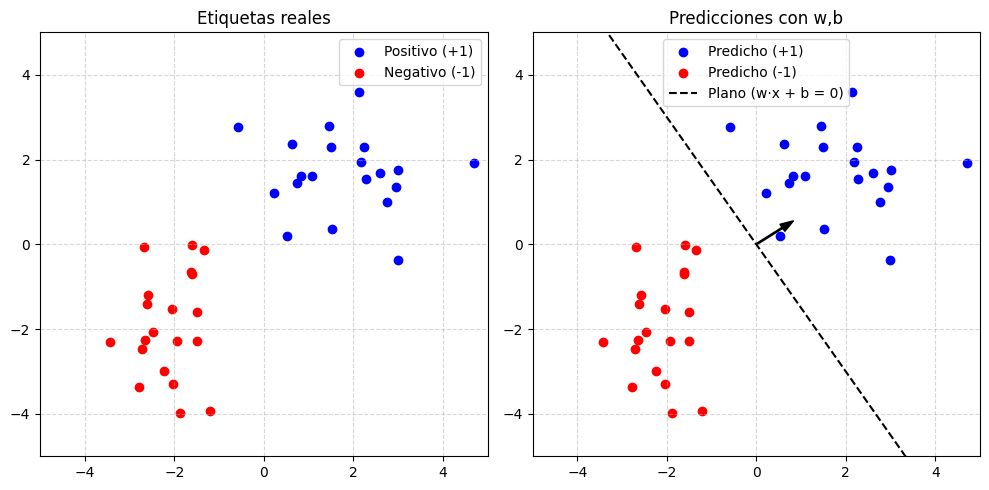

In [4]:
# =========================
# Ejemplo de uso
# =========================
# Pesos iniciales (puedes cambiarlos)
w = np.array([1.5, 1.0])
b = 0.0

plot_predictions(X, y, w, b)

In [5]:
import numpy as np

def train_perceptron(
    dataset,
    learning_rate=1.0,
    max_iterations=1000,
    initial_w=None,
    initial_b=None,
    shuffle=True,
    random_state=42
):
    """
    Entrena un perceptrón (forma online) sobre un único dataset.
    El dataset debe ser un array de forma (n, d+1) con la última columna = y en {-1, +1}.

    Parámetros:
        dataset : np.ndarray, shape (n, d+1)
        learning_rate : float
        max_iterations : int (máximo número de épocas)
        initial_w : np.ndarray o None (vector inicial de pesos, shape (d,))
        initial_b : float o None (sesgo inicial)
        shuffle : bool (baraja los ejemplos en cada época)
        random_state : int

    Retorna:
        w : np.ndarray, shape (d,)
        b : float
        y_pred : np.ndarray, shape (n,) etiquetas predichas en {-1,+1}
        n_epochs : int, número de épocas ejecutadas
        converged : bool, True si no hubo actualizaciones en la última época
    """
    rng = np.random.default_rng(random_state)

    # Separar X e y (última columna son las etiquetas)
    X = dataset[:, :-1].astype(float)
    y = dataset[:, -1].astype(float)

    # Asegurar etiquetas en {-1, +1}
    y = np.where(y <= 0, -1.0, 1.0)

    n, d = X.shape

    # Inicialización de pesos y sesgo (no cero por construcción)
    if initial_w is None:
        w = rng.normal(loc=0.0, scale=0.5, size=d)
    else:
        w = np.asarray(initial_w, dtype=float).copy()

    if initial_b is None:
        b = rng.normal(loc=0.0, scale=0.5)
        if b == 0.0:
            b = 1e-3
    else:
        b = float(initial_b)

    # Entrenamiento por épocas
    indices = np.arange(n)
    converged = False
    n_epochs = 0

    for epoch in range(1, max_iterations + 1):
        if shuffle:
            rng.shuffle(indices)

        updates = 0
        for i in indices:
            xi = X[i]
            yi = y[i]
            s = float(w @ xi + b)
            if yi * s <= 0.0:
                w += learning_rate * yi * xi
                b += learning_rate * yi
                updates += 1

        n_epochs = epoch
        if updates == 0:
            converged = True
            break

    # Predicciones finales
    scores = X @ w + b
    y_pred = np.where(scores >= 0.0, 1.0, -1.0)

    # Informe simple de convergencia
    print(f"[Perceptrón] Épocas ejecutadas: {n_epochs} | Convergencia: {converged}")

    return w, b, y_pred, n_epochs, converged

[Perceptrón] Épocas ejecutadas: 2 | Convergencia: True
Pesos entrenados: [0.34862185 0.16250531]
Sesgo entrenado: 0.27522559790322865
Número de épocas: 2
Convergió: True


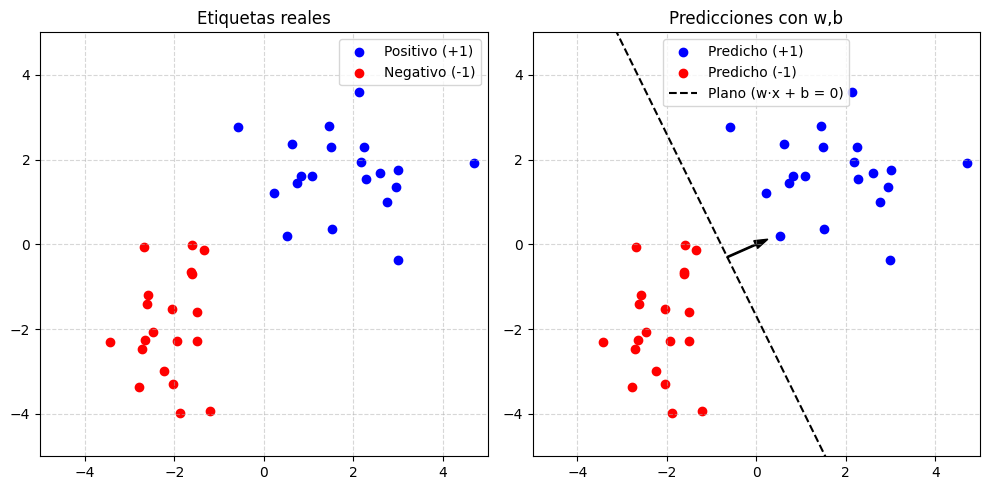

In [6]:
# Preparar dataset
# Combinar X y y en un solo array (última columna = etiqueta)
dataset = np.hstack([X, y.reshape(-1, 1)])

# Entrenar el perceptrón
w_trained, b_trained, y_pred, n_epochs, converged = train_perceptron(
    dataset=dataset,
    learning_rate=0.1,
    max_iterations=1000
)

# Imprimiendo resultados del entrenamiento
print(f"Pesos entrenados: {w_trained}")
print(f"Sesgo entrenado: {b_trained}")
print(f"Número de épocas: {n_epochs}")
print(f"Convergió: {converged}")


# Visualizar resultados
plot_predictions(X, y, w_trained, b_trained)

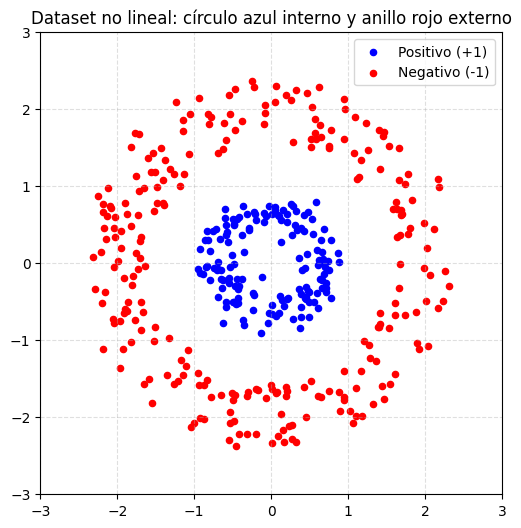

In [7]:
# Conjunto de datos No linealmente separable

rng = np.random.default_rng(7)

# Datos no linealmente separables (círculo azul interno, anillo rojo externo)
n_pos, n_neg = 150, 250

# Azul (+1): puntos cerca del centro (radio pequeño con algo de ruido)
theta_pos = rng.uniform(0, 2*np.pi, n_pos)
r_pos = rng.normal(loc=0.7, scale=0.15, size=n_pos).clip(0.0, 1.0)
x_pos2 = np.column_stack([r_pos*np.cos(theta_pos), r_pos*np.sin(theta_pos)])
y_pos2 = np.ones(n_pos)

# Rojo (-1): anillo concéntrico (radio mayor)
theta_neg = rng.uniform(0, 2*np.pi, n_neg)
r_neg = rng.uniform(1.6, 2.4, n_neg) + rng.normal(0, 0.05, n_neg)
x_neg2 = np.column_stack([r_neg*np.cos(theta_neg), r_neg*np.sin(theta_neg)])
y_neg2 = -np.ones(n_neg)

# Conjunto combinado
X2 = np.vstack([x_pos2, x_neg2])
y2 = np.concatenate([y_pos2, y_neg2])

# Gráfica
plt.figure(figsize=(6, 6))
plt.scatter(x_pos2[:, 0], x_pos2[:, 1], s=20, c='blue', label='Positivo (+1)')
plt.scatter(x_neg2[:, 0], x_neg2[:, 1], s=20, c='red', label='Negativo (-1)')
plt.gca().set_aspect('equal', 'box')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Dataset no lineal: círculo azul interno y anillo rojo externo')
plt.legend()
plt.show()

[Perceptrón] Épocas ejecutadas: 50 | Convergencia: False
Épocas: 50 | Convergió: False | Accuracy (lineal): 0.430


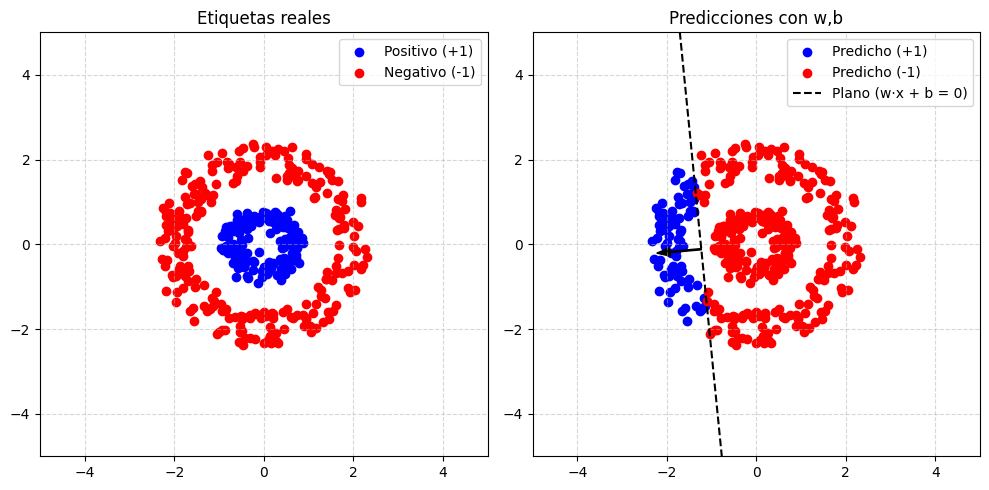

In [8]:
# Preparar dataset 2 y entrenar perceptrón (escenario no lineal)
dataset2 = np.hstack([X2, y2.reshape(-1, 1)])

w2, b2, y2_pred, n_epochs2, converged2 = train_perceptron(
    dataset=dataset2,
    learning_rate=0.1,
    max_iterations=50
)

acc2 = (y2_pred == np.where(y2 <= 0, -1.0, 1.0)).mean()
print(f"Épocas: {n_epochs2} | Convergió: {converged2} | Accuracy (lineal): {acc2:.3f}")

plot_predictions(X2, y2, w2, b2)

## Kernels (Transformaciones Espaciales agregación de dimensiones)

In [9]:
# Nueva característica cuadrática
z_feature = np.sum(X2**2, axis=1).reshape(-1, 1)

# Nuevo conjunto con la dimensión agregada
X2_poly = np.hstack([X2, z_feature])

# Convertir a DataFrame para visualizar
df_poly = pd.DataFrame(X2_poly, columns=["x1", "x2", "x3 = x1^2 + x2^2"])
df_poly["y"] = y2.astype(int)

# Mostrar primeras filas
df_poly.head(10)

,x1,x2,x3 = x1^2 + x2^2,y
0,-0.496090,-0.496686,0.492802,1
1,0.475840,-0.358610,0.355025,1
2,0.104608,-0.642538,0.423797,1
3,0.095566,0.608507,0.379413,1
4,-0.217377,0.666648,0.491673,1
5,0.451016,-0.459290,0.414363,1
6,0.654653,0.021666,0.429040,1
7,0.213438,-0.444639,0.243260,1
8,0.168744,-0.553837,0.335210,1
9,-0.928932,0.189726,0.898910,1


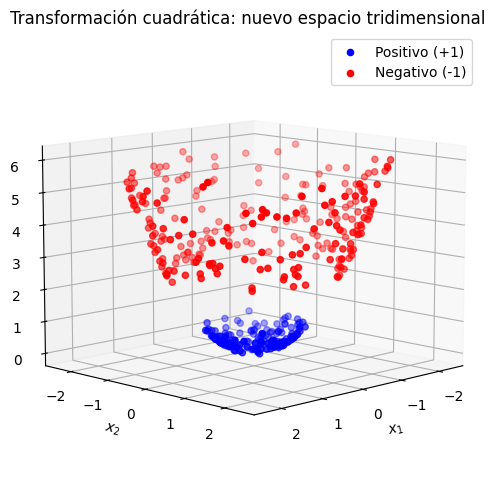

In [10]:
def plot_3d_data(X, y, elev=25, azim=45):
    """Grafica puntos 3D coloreados según su etiqueta (+1 azul, -1 rojo)."""
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    mask_pos = y == 1
    mask_neg = y == -1

    ax.scatter(X[mask_pos, 0], X[mask_pos, 1], X[mask_pos, 2],
               c='blue', label='Positivo (+1)', s=20)
    ax.scatter(X[mask_neg, 0], X[mask_neg, 1], X[mask_neg, 2],
               c='red', label='Negativo (-1)', s=20)

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3 = x_1^2 + x_2^2$")
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_title("Transformación cuadrática: nuevo espacio tridimensional")
    plt.show()


# Ejemplo de uso
plot_3d_data(X2_poly, y2, elev= 10)

In [11]:
# Preparar dataset con la nueva dimensión cuadrática
dataset3 = np.hstack([X2_poly, y2.reshape(-1, 1)])

# Entrenamiento del perceptrón en el espacio transformado
w3, b3, y3_pred, n_epochs3, converged3 = train_perceptron(
    dataset=dataset3,
    learning_rate=0.1,
    max_iterations=100
)

acc3 = (y3_pred == np.where(y2 <= 0, -1.0, 1.0)).mean()
print(f"Épocas: {n_epochs3} | Convergió: {converged3} | Accuracy (con kernel cuadrático): {acc3:.3f}")

[Perceptrón] Épocas ejecutadas: 2 | Convergencia: True
Épocas: 2 | Convergió: True | Accuracy (con kernel cuadrático): 1.000


In [12]:
def plot_3d_decision_surface(X, y, w, b, elev=25, azim=45, grid_res=40, color_by='pred'):
    # color_by: 'pred' usa predicciones, 'true' usa etiquetas reales
    X = np.asarray(X)
    y = np.asarray(y)
    assert X.ndim == 2 and X.shape[1] == 3, "Se esperan 3 columnas (x1, x2, x3)."
    assert w.shape == (3,), "w debe ser de tamaño 3."

    # Etiquetas para colorear
    if color_by == 'pred':
        yc = np.sign(X @ w + b)
    else:
        yc = np.where(y <= 0, -1, 1)

    mask_pos = (yc == 1)
    mask_neg = (yc == -1)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[mask_pos, 0], X[mask_pos, 1], X[mask_pos, 2], c='blue', s=20, label='+1')
    ax.scatter(X[mask_neg, 0], X[mask_neg, 1], X[mask_neg, 2], c='red', s=20, label='-1')

    # Plano de decisión: x3 = -(w1*x1 + w2*x2 + b) / w3
    x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_res)
    x2_vals = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_res)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    if abs(w[2]) > 1e-12:
        X3 = -(w[0] * X1 + w[1] * X2 + b) / w[2]
        ax.plot_surface(X1, X2, X3, alpha=0.35, color='gray', rstride=1, cstride=1)

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_title("Plano de decisión y puntos (color_by='{}')".format(color_by))
    plt.show()


Datos de entrenamiento en el espacio transformado:
Pesos entrenados: [-0.07595538 -0.00433347 -0.36864971]
Sesgo entrenado: 0.5702823581956069
Número de épocas: 2
Convergió: True


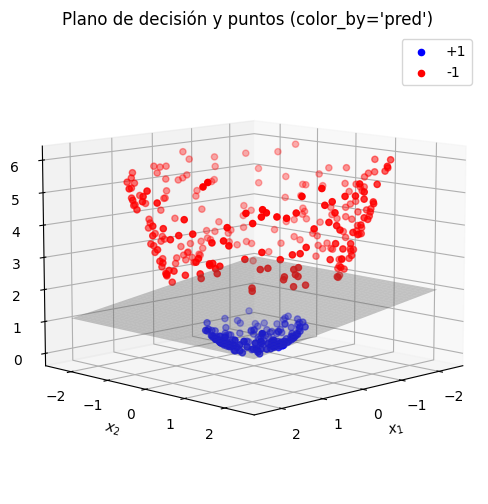

In [13]:
# Mostrando predicciónes con el plano de decisión

# Imprimiendo datos de entrenamiento
print("\nDatos de entrenamiento en el espacio transformado:")
print("Pesos entrenados:", w3)
print("Sesgo entrenado:", b3)
print("Número de épocas:", n_epochs3)
print("Convergió:", converged3)

#Mocking pesos
#w3 = np.array([0, 0, 0])

plot_3d_decision_surface(X2_poly, y2, w3, b3, elev=10)

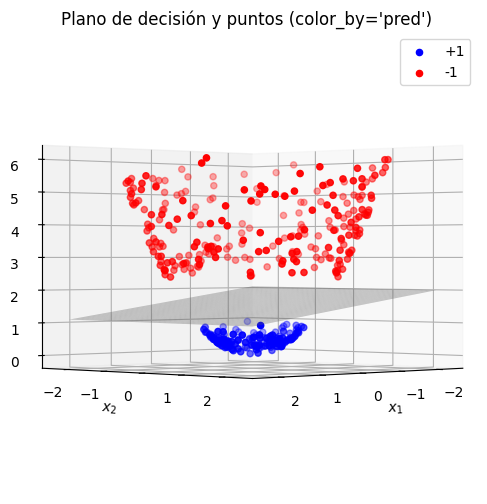

In [14]:
plot_3d_decision_surface(X2_poly, y2, w3, b3, elev=0)